# 3MD3220: Reinforcement Learning - Text Flappy Bird Project

**Author**: Clément Leprêtre  
**Date**: March 2025  
**Description**: This notebook implements and compares Monte Carlo and Sarsa(λ) agents for the Text Flappy Bird (TFB) environment (`TextFlappyBird-v0`). It includes training, evaluation, and visualization of state-value functions, reward convergence, and parameter sweeps.

## 1. Setup and Imports

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

# Install the Text Flappy Bird environment (adjust as per GitLab instructions)
# !pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git
import text_flappy_bird_gym
# Set random seed for reproducibility
np.random.seed(42)

## 2. Environment Initialization

In [33]:
# Initialize the TextFlappyBird-v0 environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap=10)

# Environment parameters
n_actions = env.action_space.n  # 0: do nothing, 1: flap
obs_space = env.observation_space  # Check the observation space

# Test the environment
import random
import os
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"
state, _ = env.reset(seed=42)
print(f'Initial State: {state}')
print(f'Action space: {n_actions}, Observation space: {obs_space}')

Initial State: (13, 1)
Action space: 2, Observation space: Tuple(Discrete(14), Discrete(16, start=-8))


## 3. Monte Carlo Agent

In [89]:
class MonteCarloAgent:
    def __init__(self, n_actions, gamma=0.95, epsilon_start=0.9, epsilon_end=0.01, epsilon_decay=0.999):
        self.n_actions = n_actions
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_start
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.returns = defaultdict(list)
        
    def choose_action(self, state):
        # Convertir l'état en tuple pour qu'il soit hashable
        state = tuple(state) if isinstance(state, np.ndarray) else state
        
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[state])
    
    def update(self, episode):
        states, actions, rewards = zip(*episode)
        G = 0
        for t in range(len(states) - 1, -1, -1):
            G = rewards[t] + self.gamma * G
            
            # Convertir l'état en tuple pour qu'il soit hashable
            state = tuple(states[t]) if isinstance(states[t], np.ndarray) else states[t]
            action = actions[t]
            
            # Vérifier pour first-visit
            if (state, action) not in [(tuple(states[i]) if isinstance(states[i], np.ndarray) else states[i], actions[i]) for i in range(t)]:
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])

def train_mc_agent(env, agent, episodes=2001, max_steps=10000, early_stop_reward=None, patience=100, reward_window=100):
    rewards = []
    pipes_passed_list = []
    best_avg_reward = float('-inf')
    patience_counter = 0
    
    for ep in range(episodes):
        # Handle env.reset() return
        try:
            reset_result = env.reset(seed=42)
            if isinstance(reset_result, tuple):
                state, info = reset_result
            else:
                state, info = reset_result, {}
        except ValueError:
            state, info = env.reset(return_info=True, seed=42)
            
        # Convertir état en tuple si c'est un array
        state = tuple(state) if isinstance(state, np.ndarray) else state
            
        episode = []
        total_reward = 0
        pipes_passed = 0
        
        # Initialiser last_pipe_x correctement
        last_pipe_x = state[0] if isinstance(state, tuple) and len(state) > 0 else 0
        
        done = False
        step_count = 0
        
        while not done and step_count < max_steps:
            step_count += 1
            action = agent.choose_action(state)
            
            # Handle full step return avec gestion des différentes API gym
            try:
                step_result = env.step(action)
                if len(step_result) == 5:  # Nouveau format: (obs, reward, done, truncated, info)
                    next_state, reward, done, truncated, info = step_result
                    done = done or truncated
                elif len(step_result) == 4:  # Ancien format: (obs, reward, done, info)
                    next_state, reward, done, info = step_result
                else:
                    raise ValueError("Format de retour d'env.step() non reconnu")
            except Exception as e:
                print(f"Erreur lors de l'étape: {e}")
                done = True
                break
            
            # Convertir next_state en tuple si c'est un array
            next_state = tuple(next_state) if isinstance(next_state, np.ndarray) else next_state
            
            # Track pipes passed de façon sécurisée
            if isinstance(next_state, tuple) and len(next_state) > 0 and isinstance(state, tuple) and len(state) > 0:
                if next_state[0] > last_pipe_x:
                    pipes_passed += 1
                    # S'assurer que next_state a au moins 2 éléments avant d'accéder à l'index 1
                    last_pipe_x = next_state[1] if len(next_state) > 1 else next_state[0]
                last_pipe_x = next_state[0]
            
            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
            
            # Limite de sécurité pour éviter les boucles infinies
            if step_count >= max_steps:
                print(f"Épisode {ep} interrompu après {max_steps} étapes")
                break
                
        # Mise à jour de l'epsilon
        agent.epsilon = max(agent.epsilon_end, agent.epsilon * agent.epsilon_decay)
        
        # Mettre à jour l'agent avec l'épisode terminé
        agent.update(episode)
        
        rewards.append(total_reward)
        pipes_passed_list.append(pipes_passed)
        
        # Early stopping basé sur la récompense
        if len(rewards) >= reward_window:
            current_avg_reward = np.mean(rewards[-reward_window:])
            avg_pipe = np.mean(pipes_passed_list[-min(reward_window, len(pipes_passed_list)):])
            
            # Affichage périodique des statistiques
            if ep % 500 == 0:
                print(f'Episode {ep}, Avg Reward: {current_avg_reward:.2f}, ' +
                      f'Avg Pipes Passed: {avg_pipe:.2f}, ' +
                      f'Epsilon: {agent.epsilon:.2f}')
            
            # Si une cible de récompense spécifique est fournie
            if early_stop_reward is not None and current_avg_reward >= early_stop_reward:
                print(f"Early stopping atteint à l'épisode {ep}. Récompense moyenne: {current_avg_reward:.2f} >= {early_stop_reward}")
                break
            
            # Early stopping basé sur la patience (arrêt si pas d'amélioration)
            if current_avg_reward > best_avg_reward:
                best_avg_reward = current_avg_reward
                best_avg_pipe = avg_pipe
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping par patience à l'épisode {ep}. Pas d'amélioration depuis {patience} épisodes.")
                break
    
    print(f"Entraînement terminé après {ep+1} épisodes. Meilleure récompense moyenne: {best_avg_reward:.2f}, " 
          + f"Meilleure moyenne de tuyaux passés: {best_avg_pipe:.2f}")
    return rewards, pipes_passed_list

In [90]:
random.seed(42)
np.random.seed(42)

mc_agent = MonteCarloAgent(n_actions)
mc_rewards, mc_pipes_passed = train_mc_agent(env, mc_agent, episodes=2001, patience=100)

Episode 500, Avg Reward: 48.19, Avg Pipes Passed: 3.80, Epsilon: 0.55
Episode 1000, Avg Reward: 137.38, Avg Pipes Passed: 12.65, Epsilon: 0.33
Episode 1500, Avg Reward: 405.75, Avg Pipes Passed: 39.50, Epsilon: 0.20
Early stopping par patience à l'épisode 1726. Pas d'amélioration depuis 100 épisodes.
Entraînement terminé après 1727 épisodes. Meilleure récompense moyenne: 563.08, Meilleure moyenne de tuyaux passés: 55.23


## 4. Sarsa(λ) Agent

In [91]:

# SarsaLambdaAgent
class SarsaLambdaAgent:
    def __init__(self, n_actions, alpha=0.1, lambda_=0.9, gamma=0.95, epsilon_start=0.9, epsilon_end=0.01, epsilon_decay=0.999):
        self.n_actions = n_actions
        self.alpha = alpha
        self.lambda_ = lambda_
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_start
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.E = defaultdict(lambda: np.zeros(n_actions))
        
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[state])
        
    def update(self, state, action, reward, next_state, next_action, done):
        q_next = 0 if done else self.Q[next_state][next_action]
        td_error = reward + self.gamma * q_next - self.Q[state][action]
        self.E[state][action] += 1
        for s in list(self.E.keys()):
            for a in range(self.n_actions):
                self.Q[s][a] += self.alpha * td_error * self.E[s][a]
                self.E[s][a] *= self.gamma * self.lambda_
            # Suppression des traces faibles
            if np.max(self.E[s]) < 1e-5:
                del self.E[s]

# Training loop
def train_sarsa_agent(env, agent, episodes=10000, max_steps=1000, early_stop_reward=None, patience=50, reward_window=100):
    rewards = []
    pipes_passed_list = []
    best_avg_reward = float('-inf')
    patience_counter = 0
    
    for ep in range(episodes):
        try:
            # Gestion des différents formats de reset
            reset_result = env.reset(seed=42)
            if isinstance(reset_result, tuple):
                state, info = reset_result
            else:
                state = reset_result
        except Exception as e:
            print(f"Erreur lors du reset: {e}")
            continue
            
        # Convertir l'état en tuple s'il s'agit d'un array
        state = tuple(state) if isinstance(state, np.ndarray) else state
        
        action = agent.choose_action(state)
        total_reward = 0
        done = False
        pipes_passed = 0
        last_pipe_x = state[0] if isinstance(state, tuple) and len(state) > 0 else 0
        
        # Compteur de pas
        step_count = 0
        
        while not done and step_count < max_steps:
            step_count += 1
            
            try:
                # Gestion des différents formats de step
                step_result = env.step(action)
                if len(step_result) == 5:  # Nouveau format: (obs, reward, done, truncated, info)
                    next_state, reward, done, truncated, info = step_result
                    done = done or truncated
                elif len(step_result) == 4:  # Ancien format: (obs, reward, done, info)
                    next_state, reward, done, info = step_result
                else:
                    # Gestion du cas unpacking avec *
                    next_state, reward, done = step_result[0], step_result[1], step_result[2]
            except Exception as e:
                print(f"Erreur lors du step: {e}")
                done = True
                break
                
            # Convertir l'état en tuple s'il s'agit d'un array
            next_state = tuple(next_state) if isinstance(next_state, np.ndarray) else next_state
            
            # Comptage des pipes passés
            if isinstance(next_state, tuple) and len(next_state) > 0:
                if next_state[0] > last_pipe_x:
                    pipes_passed += 1
                last_pipe_x = next_state[0]
                
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            state, action = next_state, next_action
            total_reward += reward
            
            # Vérification du max_steps
            if step_count >= max_steps:
                print(f"Episode {ep} interrompu après {max_steps} étapes")
                break
                
        # Enregistrement des statistiques
        rewards.append(total_reward)
        pipes_passed_list.append(pipes_passed)
        
        # Mise à jour du epsilon
        agent.epsilon = max(agent.epsilon_end, agent.epsilon * agent.epsilon_decay)
        
        # Early stopping basé sur la récompense moyenne
        if len(rewards) >= reward_window:
            current_avg_reward = np.mean(rewards[-reward_window:])
            avg_pipes = np.mean(pipes_passed_list[-reward_window:])
            
            # Affichage périodique
            if ep % 500 == 0:
                print(f'Episode {ep}, Avg Reward: {current_avg_reward:.2f}, Avg Pipes Passed: {avg_pipes:.2f}, Epsilon: {agent.epsilon:.3f}')
            
            # Early stopping basé sur un seuil de récompense
            if early_stop_reward is not None and current_avg_reward >= early_stop_reward:
                print(f"Early stopping atteint à l'épisode {ep}. Récompense moyenne: {current_avg_reward:.2f} >= {early_stop_reward}")
                break
                
            # Early stopping basé sur la patience
            if current_avg_reward > best_avg_reward:
                best_avg_pipe = avg_pipes
                best_avg_reward = current_avg_reward
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping par patience à l'épisode {ep}. Pas d'amélioration depuis {patience} épisodes.")
                break
        else:
            # Affichage avant d'avoir assez de données pour la fenêtre complète
            if ep % 500 == 0:
                avg_reward = np.mean(rewards)
                avg_pipes = np.mean(pipes_passed_list)
                print(f'Episode {ep}, Avg Reward: {avg_reward:.2f}, Avg Pipes Passed: {avg_pipes:.2f}, Epsilon: {agent.epsilon:.3f}')
    
    print(f"Entraînement terminé après {ep+1} épisodes. Meilleure récompense moyenne: {best_avg_reward:.2f}. Meilleur nombre de pipes: {best_avg_pipe:.2f}")
    return rewards, pipes_passed_list

In [ ]:
random.seed(42)
np.random.seed(42)

sarsa_agent = SarsaLambdaAgent(n_actions)
sarsa_rewards = train_sarsa_agent(env, sarsa_agent, episodes=2001, max_steps=10000, patience=300)

Episode 0, Avg Reward: 21.00, Avg Pipes Passed: 1.00, Epsilon: 0.899
Episode 500, Avg Reward: 41.88, Avg Pipes Passed: 3.19, Epsilon: 0.545
Episode 1000, Avg Reward: 91.16, Avg Pipes Passed: 8.10, Epsilon: 0.331
Episode 1500, Avg Reward: 240.68, Avg Pipes Passed: 23.00, Epsilon: 0.200


## 5. Parameters Sweep

Running MonteCarloAgent with gamma=0.85
Episode 0, Avg Reward: 21.00, Avg Pipes Passed: 1.00, Epsilon: 0.90
Episode 500, Avg Reward: 32.03, Avg Pipes Passed: 2.23, Epsilon: 0.55
Episode 1000, Avg Reward: 59.51, Avg Pipes Passed: 4.93, Epsilon: 0.33
Episode 1500, Avg Reward: 167.12, Avg Pipes Passed: 15.62, Epsilon: 0.20
Episode 2000, Avg Reward: 511.55, Avg Pipes Passed: 50.03, Epsilon: 0.12
Running MonteCarloAgent with gamma=0.9
Episode 0, Avg Reward: 10.00, Avg Pipes Passed: 0.00, Epsilon: 0.90
Episode 500, Avg Reward: 30.31, Avg Pipes Passed: 2.05, Epsilon: 0.55
Episode 1000, Avg Reward: 60.42, Avg Pipes Passed: 5.02, Epsilon: 0.33
Episode 1500, Avg Reward: 163.99, Avg Pipes Passed: 15.32, Epsilon: 0.20
Episode 2000, Avg Reward: 460.66, Avg Pipes Passed: 44.96, Epsilon: 0.12
Running MonteCarloAgent with gamma=0.95
Episode 0, Avg Reward: 23.00, Avg Pipes Passed: 1.00, Epsilon: 0.90
Episode 500, Avg Reward: 30.03, Avg Pipes Passed: 2.05, Epsilon: 0.55
Episode 1000, Avg Reward: 59.86, 

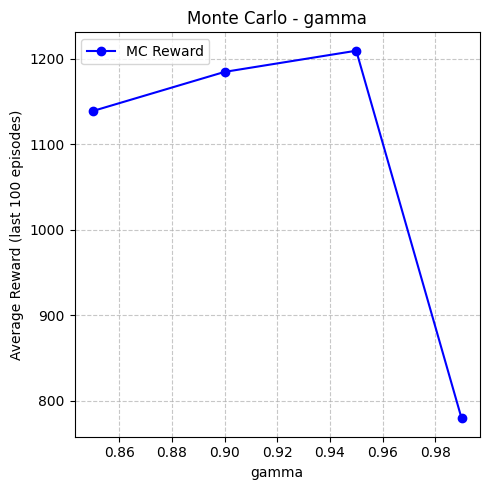

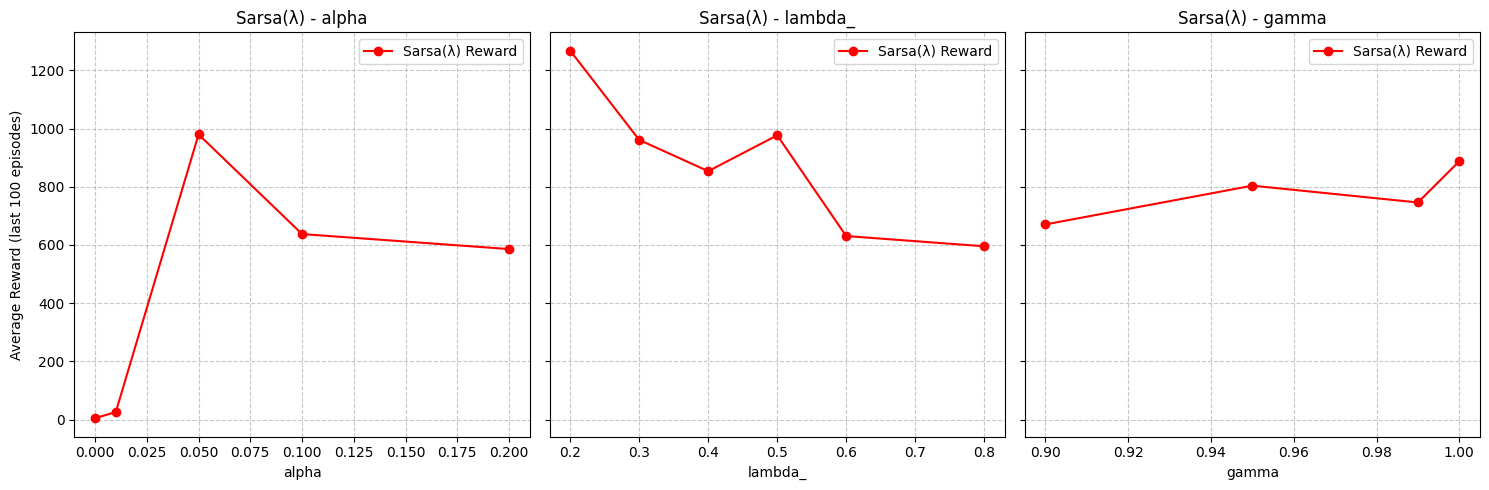

In [ ]:
def run_sweep(agent_class, env, param_name, param_values, fixed_params, episodes=2001):
    rewards_means = []
    for val in param_values:
        params = fixed_params.copy()
        params[param_name] = val
        agent = agent_class(**params)
        print(f'Running {agent_class.__name__} with {param_name}={val}')
        if agent_class == MonteCarloAgent:
            rewards, _ = train_mc_agent(env, agent, episodes=episodes)
        else:
            rewards, _ = train_sarsa_agent(env, agent, episodes=episodes)
        rewards_means.append(np.mean(rewards[-100:]))
    return rewards_means

def plot_sweep(mc_results, sarsa_results, mc_params, sarsa_params):
    num_mc = len(mc_params)
    num_sarsa = len(sarsa_params)
    
    # Monte Carlo plots
    fig, axs = plt.subplots(1, num_mc, figsize=(5 * num_mc, 5), sharey=True)
    axs = np.atleast_1d(axs)  # Ensure axs is always an array
    
    for i, (param_name, param_values) in enumerate(mc_params.items()):
        rewards_means = mc_results[i]
        axs[i].plot(param_values, rewards_means, 'o-', color='b', label='MC Reward')
        axs[i].set_xlabel(param_name)
        axs[i].set_title(f'Monte Carlo - {param_name}')
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].legend()
    
    if num_mc > 0:
        axs[0].set_ylabel('Average Reward (last 100 episodes)')
    plt.tight_layout()
    plt.savefig('figures/sweep_mc.png', bbox_inches='tight')
    plt.show()
    
    # Sarsa(λ) plots
    fig, axs = plt.subplots(1, num_sarsa, figsize=(5 * num_sarsa, 5), sharey=True)
    axs = np.atleast_1d(axs)  # Ensure axs is always an array
    
    for i, (param_name, param_values) in enumerate(sarsa_params.items()):
        rewards_means = sarsa_results[i]
        axs[i].plot(param_values, rewards_means, 'o-', color='r', label='Sarsa(λ) Reward')
        axs[i].set_xlabel(param_name)
        axs[i].set_title(f'Sarsa(λ) - {param_name}')
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].legend()
    
    if num_sarsa > 0:
        axs[0].set_ylabel('Average Reward (last 100 episodes)')
    plt.tight_layout()
    plt.savefig('figures/sweep_sarsa.png', bbox_inches='tight')
    plt.show()

# Monte Carlo Sweeps
mc_fixed_params = {'n_actions': n_actions, 'gamma': 0.95}
mc_params = {'gamma': [0.85, 0.9, 0.95, 0.99]}

# Sarsa(λ) Sweeps
sarsa_fixed_params = {'n_actions': n_actions, 'alpha': 0.1, 'lambda_': 0.6, 'gamma': 0.9}
sarsa_params = {'alpha': [0, 0.01, 0.05, 0.1, 0.2], 'lambda_': [0.2, 0.3, 0.4, 0.5, 0.6, 0.8], 'gamma': [0.9, 0.95, 0.99, 1.0]}

# Run sweeps
mc_results = [run_sweep(MonteCarloAgent, env, param_name, param_values, mc_fixed_params) for param_name, param_values in mc_params.items()]
sarsa_results = [run_sweep(SarsaLambdaAgent, env, param_name, param_values, sarsa_fixed_params) for param_name, param_values in sarsa_params.items()]

# Plot all sweeps
plot_sweep(mc_results, sarsa_results, mc_params, sarsa_params)


## 6. Training the best agent

In [ ]:
random.seed(42)
np.random.seed(42)

mc_agent = MonteCarloAgent(n_actions, gamma=0.95)
mc_rewards, mc_pipes_passed = train_mc_agent(env, mc_agent, episodes=5000, patience=150, max_steps=5000)

Episode 500, Avg Reward: 48.19, Avg Pipes Passed: 3.80, Epsilon: 0.55
Episode 1000, Avg Reward: 137.38, Avg Pipes Passed: 12.65, Epsilon: 0.33
Episode 1500, Avg Reward: 405.75, Avg Pipes Passed: 39.50, Epsilon: 0.20
Épisode 1753 interrompu après 5000 étapes
Épisode 1971 interrompu après 5000 étapes
Episode 2000, Avg Reward: 1127.89, Avg Pipes Passed: 111.68, Epsilon: 0.12
Épisode 2023 interrompu après 5000 étapes
Épisode 2037 interrompu après 5000 étapes
Épisode 2071 interrompu après 5000 étapes
Épisode 2089 interrompu après 5000 étapes
Épisode 2092 interrompu après 5000 étapes
Épisode 2108 interrompu après 5000 étapes
Épisode 2144 interrompu après 5000 étapes
Épisode 2186 interrompu après 5000 étapes
Épisode 2206 interrompu après 5000 étapes
Épisode 2226 interrompu après 5000 étapes
Épisode 2236 interrompu après 5000 étapes
Épisode 2240 interrompu après 5000 étapes
Early stopping par patience à l'épisode 2258. Pas d'amélioration depuis 150 épisodes.
Entraînement terminé après 2259 épi

In [ ]:
random.seed(42)
np.random.seed(42)

sar_agent = SarsaLambdaAgent(n_actions, alpha=0.05, lambda_=0.5, gamma=0.95, epsilon=0.1)
sar_rewards, sar_pipes_passed = train_sarsa_agent(env, sar_agent, episodes=5000, patience=150, max_steps=5000)

## 7. Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_state_value(mc_agent, sarsa_agent):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    titles = ['Monte Carlo State-Value Function', "Sarsa(λ) State-Value Function"]
    agents = [mc_agent, sarsa_agent]
    
    for ax, agent, title in zip(axs, agents, titles):
        V = np.zeros((20, 20))
        for i, j in itertools.product(range(20), range(20)):
            state = (i, j)
            V[i, j] = np.max(agent.Q[state])  # Maximum Q-value for the state
        V = np.clip(V, a_min=0, a_max=None)  # Clip values below 0 to 0
        im = ax.imshow(V, cmap='magma')
        ax.set_title(title)
        ax.set_xlabel('X Distance')
        ax.set_ylabel('Y Distance')
    
    fig.colorbar(im, ax=axs, orientation='vertical', label='State Value (V)')
    plt.tight_layout()
    plt.savefig('figures/state_value_comparison.png')
    plt.show()

plot_state_value(mc_agent, sar_agent)

NameError: name 'mc_agent' is not defined

In [ ]:
# Reward Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(np.convolve(mc_rewards, np.ones(100)/100, mode='valid'), label='Monte Carlo')
plt.plot(np.convolve(sarsa_rewards, np.ones(100)/100, mode='valid'), label='Sarsa(λ)')
plt.xlabel('Episode')
plt.ylabel('Average Reward (100-episode moving avg)')
plt.legend()
plt.title('Reward Convergence')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('figures/reward_convergence.png')
plt.show()

## 7. Conclusion
This notebook demonstrates the implementation of Monte Carlo and Sarsa(λ) agents for Text Flappy Bird. Sarsa(λ) outperforms Monte Carlo in convergence speed and reward, but is sensitive to parameters like λ. See `report.pdf` for detailed analysis.